In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### VISUALIZE AND QUANTIZE 

In [155]:
"""
Cell Purpose: Load all the gesture training data and append it to two variables

Variable: 
- time_data: "Specific times that acceleration was observed"
- acceleration_data: "Specific linear and angular acceleration at specific times"

Variable Shapes: 
- time_data = (4111, 1) = (# instances, 1 Time)
- acceleration_data = (4111, 6) = (# Instances, 6 acceleration columns)
"""

def load_file(file_name):
    return np.loadtxt(file_name)

fname = "Data/ECE5242Proj2_train_additional-selected/wave31.txt"
gesture_data = load_file(fname)
time_data = gesture_data[:, 0][:, np.newaxis]
acceleration_data = gesture_data[:, 1:]

# # Append all of the gesture data which we will discretize the data 
# for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
#     fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
#     path = os.path.join("Data/ECE5242Proj2_train_additional-selected/", fname)
#     gesture_data = load_file(path)

#     if i == 0:
#         time_data = gesture_data[:, 0][:, np.newaxis]
#         acceleration_data = gesture_data[:, 1:]
#     else:
#         time_data = np.row_stack((time_data, gesture_data[:, 0][:, np.newaxis])) # NOT SURE IF THIS IS CORRECT
#         acceleration_data = np.row_stack((acceleration_data, gesture_data[:, 1:]))

print(acceleration_data.shape, time_data.shape)

(441, 6) (441, 1)


/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


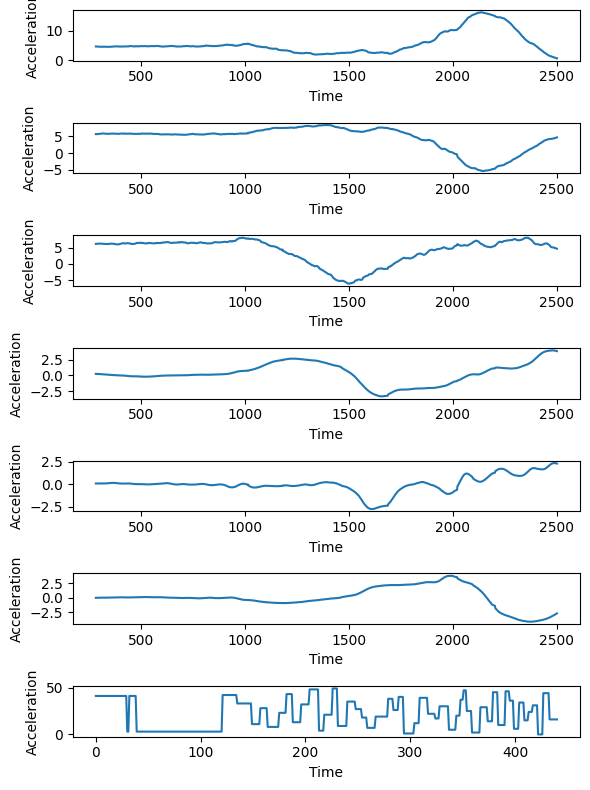

In [156]:
"""
Cell Purpose: Use KMeans to discretize the raw sensor data which is seen in the last graph. 

Variables:
- num_of_clusters = "using kmeans to create clusters which brings down the number of dimensions from 6 to 1"
- M = "discrete observations or KMeans clusters"
- O = "Observations"

Variable Shapes:
- num_of_clusters = float

"""
def plot_continuous_discrete(clusters, time, acceleration):
    # Plot the data
    fig, axs = plt.subplots(nrows=7, ncols=1, sharex=False, sharey=False, figsize=(6, 8))

    # Plot each channel in a separate subplot
    for i, ax in enumerate(axs):
        if i < 6:
            ax.plot(time, acceleration[:, i])
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')
        else:
            ax.plot(clusters)
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')

    # # Adjust the layout and spacing of the subplots
    fig.tight_layout()

    # Show the plot
    plt.show()


M = 50
O = KMeans(n_clusters=M).fit_predict(acceleration_data)
plot_continuous_discrete(O, time_data, acceleration_data)

## IMPLEMENT HMM

In [345]:
"""
Cell Purpose: Initialize the model parameters

Variables:
- N: Number of states
- M: Number of observation classes or clusters
- A: Transition Matrix
- pi: Initial probability we are in a a specific state

Variable Shapes
- N: float
- A: (Number of states, number of states)
- pi: (N, 1)
"""

def init_a_matrix(N):
    A = np.zeros((N, N))
    for i in range(N):
        A[i, i] = 0.5
        if i + 1 < N:
            A[i + 1, i] = 0.5
    
    A[0, -1] = 0.5 # This is to make sure it can transition to another state
    return A

def init_pi_matrix(N):
    pi = np.zeros((N))
    pi[0] = 1
    return pi

def init_b_matrix(N, M):
    arr = np.random.rand(N, M)
    arr = arr / np.sum(arr, axis=1, keepdims=True)
    return arr

N = 10
A = init_a_matrix(N)
B = init_b_matrix(N, M)
pi = init_pi_matrix(N)

print("\nA: ", A)
print("\nB: ", B)
print("\nPi: ", pi)
print("\nO: ", O)


A:  [[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]]

B:  [[3.11570577e-02 2.44753792e-02 2.52571663e-02 2.29702413e-02
  2.72937075e-02 2.62506081e-02 6.67386172e-04 1.06644319e-02
  3.10477783e-02 2.48248403e-02 8.20207773e-03 2.92448439e-02
  2.82091720e-02 1.29901073e-02 2.52833713e-02 3.20623955e-02
  2.81759631e-02 1.50639026e-02 1.73365943e-02 4.39811675e-03
  3.38749378e-02 2.08478146e-02 1.66882001e-02 1.83659510e-02
  3.25880891e-02 2.54741751e-03 2.16483637e-02 3.26873707e-02
  3.21637043e-02 2.61039351e-02 1.02967549e-02 5.22917445e-03
  2.78743611e-02 1.32967744e-03 1.55910727e-02 1.02896001e-03
 

In [460]:
"""
Variables:
- O: "Each observation is assigned a cluster number which also indicates"
- B: "Observation/Emission Matrix"
- pi: "Initial state probabilities"
- Alpha: "Probability you are in state j given a sequence of observations up to t-1"
- Beta: "Probability of seeing a sequence of future observations"
- A: "Transition Matrix"
- Gamma: "Probability of being in state i at time T"
- Chi: "Probability of going from state i to state j given observation sequence"
- c: "Scaling factor to prevent underflow"


Variable Shapes:
- O: (4111,) = (Gesture Instances, 1)
- B: (10 , 50) = (Number of hidden states, Number of clusters)
- pi: (10, 1) = (Number of hidden states, 1)
- Alpha: ( Length of the observation sequence, Number of hidden states)
- Beta: (Length of observation sequence, Number of hidden states)
- A: (Number of hidden states, number of hidden states))
- Gamma: (Number of hidden states, Length of observation sequence)
- Chi: (Number of hidden states, Number of hidden states, Length of observation sequence)
- c: (Length of observation sequence)
"""

class HMM():
    def __init__(self, N, M, A, B, pi, O):
        self.N = N
        self.M = M
        self.A = A
        self.B = B
        self.pi = pi
        self.O = O
        self.T = self.O.shape[0] # Length of the sequence

    def calculate_alpha(self):
        alpha = np.zeros((self.T, self.N))
        c = np.ones((self.T))

        # Calculate base case
        alpha[0, :] = self.pi * self.B[:, self.O[0]]
        c[0] = 1 / np.sum(alpha[0, :]) # Scaling factor take -log at the end to revert
        alpha[0, :] = c[0] * alpha[0, :]
        
        # Inductive step
        for t in range(1, self.T):
            for i in range(1, self.N):
                alpha[t, i] = np.sum(alpha[t-1, :] * self.A[i, :]) * self.B[i, self.O[t]]
            c[t] = 1 / np.sum(alpha[t, :])
            alpha[t, :] = c[t] * alpha[t, :]

        return alpha, c
    
    def calculate_beta(self, c):
        beta = np.zeros((self.T, self.N))

        # Calculate base case
        beta[self.T - 1, :] = 1
        beta[self.T - 1, :] = c[self.T-1] * beta[self.T - 1, :]

        # inductive step
        for t in range((self.T - 2), -1, -1):
            for i in range(self.N):
                beta[t, i] = np.sum(self.A[:, i] * self.B[:, self.O[t + 1]] * beta[t+1, :])
            beta[t, :] = c[t] * beta[t, :]

        return beta
    
    def calculate_gamma(self, alpha, beta):
        gamma = np.zeros((self.N, self.T))
        
        for i in range(self.N):
            for t in range(self.T):
                gamma[i, t] = (alpha[t, i] * beta[t, i]) / np.sum(alpha[t, :] * beta[t, :]) # NOT SURE IF YOU HAVE TO STATE AXIS HERE
        
        return gamma
    
    def calculate_chi(self, alpha, beta):
        chi = np.zeros((self.N, self.N, self.T))

        for i in range(self.N):
            for j in range(self.N):
                for t in range(self.T - 1):
                    numerator = alpha[t, i] * self.A[j, i] * self.B[j, O[t + 1]] * beta[t+1, j]
                    # denominator = np.sum(numerator)
                    denominator = np.sum(alpha[t, :] * self.A[:, j] * self.B[j, self.O[t + 1]] * beta[t+1, :]) # NOT SURE ABOUT THIS
                    chi[i, j, t] = numerator / denominator
        
        return chi
    
    def adjust_a(self, chi, gamma):
        for i in range(self.N):
            for j in range(self.N):
                # self.A[j, i] = np.sum(chi[i, j, :self.T-1]) / np.sum(chi[i, j, :self.T-1])
                self.A[j, i] = np.sum(chi[i, j, :self.T-1]) / np.sum(gamma[i, :self.T-1])

        return self.A
    
    def adjust_b(self, gamma):
        for i in range(self.N):
            for o in range(self.M):
                self.B[i, o] = np.sum(gamma[i, self.O==o]) / np.sum(gamma[i, :]) # Not sure if this is right

        return self.B

    def Baum_Welsh(self):
        # Forward
        alpha, c = self.calculate_alpha()

        # Backward
        beta = self.calculate_beta(c)

        # E Step
        gamma = self.calculate_gamma(alpha, beta)
        chi = self.calculate_chi(alpha, beta)

        # M Step
        pi = gamma[:, 0]
        A = self.adjust_a(chi, gamma)
        B = self.adjust_b(gamma)

        # Calculate likelihood
        


        return A, B, pi
        

In [461]:
def train_model(epochs, N, M, A, B, pi, O):
    model = HMM(N, M, A, B, pi, O)
    for epoch in range(epochs):
        A, B, pi = model.Baum_Welsh()
        print("Epoch: ", epoch)

train_model(500, N, M, A, B, pi, O)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch:  0
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch:  1
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... na

KeyboardInterrupt: 